# KW-Distance: Two alternatives LP Models
In this notebook, we write a basic Linear Programming (LP) model to approximate the Kantorovich-Wasserstein distance of order 1 between a pair of discrete measures, such as, for instance, a pair of gray scale images.

In order to assess computationally the deviance of our model from the optimal solution, we implement first a standard LP model defined on a bipartite graph, which has a quadratic number of variables. Later, we show how to implement our compact model.

In the following, for the easy of notation, we consider discrete measures with $N$ support points defined as sum of Diracs as follows:

$$\mu = \sum_{i=1,\dots,N} \mu_i \delta(x_i)$$

where $\mu_i$ is the quantity of mass located at position $x_i$, and $\delta(x_i)=1$ only at position $x_i$, and it is equal to zero, otherwise.

### Exact Bipartite Model
We begin with given the standard bipartite LP model. Given two discrete measutes $\mu$ and $\nu$ defined on 2-dimensional histograms (i.e., a regular grid) with $N=n \times n$ bins, we define a bipartite graph $G=(V \cup W, E)$ as follows. We have a node $v \in V$ for each support point of the first measure $\mu$ and a node $w \in W$ for each support point of the second measure $\nu$. Note that we need to consider only support points a strictly positive quantity of mass (we can ignore all the bins without mass). Then, we add an edge $\{i,j\} \in E$ with cost $c_{ij} = d_{ij} = \sqrt{||x_i - x_j||}$, whenever both $\mu_i>0$ and $\nu_j>0$.

Given the bipartite graph $G=(V \cup W, E)$, we can write the following LP model:

$$\begin{align}
\min \quad & \sum_{ij \in E} c_{ij} \pi_{ij} \\
\mbox{s.t.} \quad 
& \sum_{ij \in E} \pi_{ij} = \mu_i, & \forall i \in V \\
& \sum_{ij \in E} \pi_{ij} = \nu_j, & \forall j \in W \\
& \pi_{ij} \geq 0, & \forall \{i,j\} \in E.
\end{align}$$

The variable $\pi_{ij}$ are the decision variables that indicate the quantity of mass to be moved from position $x_i$ to $x_j$.

### Installing PYOMO and GLPK
We show next how to implement the previous model using the [Pyomo](https://pyomo.readthedocs.io/en/stable/index.html) optimization modeling language and the [GLPK](https://www.gnu.org/software/glpk/) open source MILP solver.

In [ ]:
import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("glpk") or os.path.isfile("glpk")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq glpk-utils
    else:
        try:
            !conda install -c conda-forge glpk 
        except:
            pass

From Pyomo, we use the following procedures for writing our LP models:

In [1]:
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory
from pyomo.environ import RangeSet, ConstraintList, NonNegativeReals

### Creating random 2D discrete measures
In order to store a random discrete measure, with support $N$ points randomly located over the space of a square grid of size $M \times M$, we use the following class

In [2]:
import numpy as np
# Support function to normalize a numpy vector
Normalize = lambda x: x/sum(x)

# We define a data type for 2D-histograms as defined before
class Measure2D(object):
    def __init__(self, N, M=32, seed=13):
        """ default c'tor: N random points """
        # Fix the seed for debugging
        np.random.seed(seed)
        # N random weights
        self.W = Normalize(np.random.uniform(0, 1, size=N))
        # N random support points
        x = set()
        while len(x) < N:
            x.add((np.random.randint(1, M), 
                   np.random.randint(1, M)))
        self.X = list(x)
        # Map point to weight
        self.D = {}
        for i in range(N):
            self.D[self.X[i]] = self.W[i]

And to create two random measures over a grid of size $32 \times 32$, the first with 300 support points, and the second with 200 support points:

In [3]:
# Create two random measures
GridSize = 32

Mu = Measure2D(300, GridSize, seed=13)
Nu = Measure2D(200, GridSize, seed=14)

Later on, we need a cost function between a pair of support points defined in $\mathbb{R}^2$.

In [4]:
from math import sqrt
# Euclidean distance in the plane
Cost = lambda x, y: sqrt((x[0] - y[0])**2 + (x[1] - y[1])**2)

## Solving the Bipartite model
Given two discrete measures $\mu$ and $\nu$, we can use an implicit definition of the bipartite graph, by defining directly the following function, whichi implements and solves LP model described before.

In [5]:
# Others useful libraries
from time import time

# Second, we write a function that implements the model, solves the LP, 
# and returns the KW distance along with an optimal transport plan.
def BipartiteDistanceW1_L2(Mu, Nu):
    t0 = time()
    # Main Pyomo model
    model = ConcreteModel()
    # Parameters
    model.I = RangeSet(len(Mu.X))
    model.J = RangeSet(len(Nu.X))
    # Variables
    model.PI = Var(model.I, model.J, within=NonNegativeReals) 
    # Objective Function
    model.obj = Objective(
        expr=sum(model.PI[i,j] * Cost(Mu.X[i-1], Nu.X[j-1]) for i,j in model.PI))
    
    # Constraints on the marginals
    model.Mu = Constraint(model.I, 
                          rule = lambda m, i: sum(m.PI[i,j] for j in m.J) == Mu.W[i-1])
    model.Nu = Constraint(model.J, 
                          rule = lambda m, j: sum(m.PI[i,j] for i in m.I) == Nu.W[j-1])
    
    # Solve the model
    sol = SolverFactory('glpk').solve(model)

    # Get a JSON representation of the solution
    sol_json = sol.json_repn()
    # Check solution status
    if sol_json['Solver'][0]['Status'] != 'ok':
        return None
    if sol_json['Solver'][0]['Termination condition'] != 'optimal':
        return None

    return model.obj(), time()-t0

In order to compute the distance between the two models, we have only to call our function with the two discrete meausures randomly defined before.

In [6]:
# Compute distance and runtime
distA, runtimeA = BipartiteDistanceW1_L2(Mu, Nu)

In [7]:
print("Optimal distance: {}, runtime: {}".format(distA, runtimeA))

Optimal distance: 2.3510932706221777, runtime: 10.579878091812134


In the following, we look at a different LP model which approximately solves an equivalent problem.

## Approximate LP model
In the this section, we show how we can solve the very same problem by using a likely smaller LP model. Note that for very samll instances, the difference might be invisible, but as the input measure scale up in size, the difference become quickly relevant.

The main idea is to exploit the cost structure of Kantorovich-Wasserstein distance, which permit to formulate the same problem on a flow network instead of using a bipartite graph. We can however prove that under given assumptions, the two problem formulations are equivalent.

Given two discrete measutes $\mu$ and $\nu$ defined on 2-dimensional histograms (i.e., a regular grid) with $N=n \times n$ bins, we define an uncapacitated network flow $G=(V, E, b)$ as follows. We have a node $v \in V$ for each bin, with support point $x_v=(i,j)$ with $0 \leq i,j \leq n-1$. Each node $v \in V$ has a flow balance $b_v = \mu_v - \nu_v$: if $b_v > 0$ then node $v$ is a source node; if $b_v < 0$ node $v$ is a sink node, otherwise, whenever $b_v=0$ node $v$ is a transit node. In addition, we have and edge $\{i,j\} \in E$ with cost $c_{ij} = d_{ij} = \sqrt{||x_i - x_j||}$, whenever a specific condition is verified between the pair of support points $x_i$ and $x_j$. The way we specify this condition is the core of our contribution in [1]. For the moment, suppose we have a link between any pair of bins.

At this point, if we look for a minimum flow from the source nodes to the sink nodes, we find the minimum cost of moving the first measure into the second at minimum cost. That is, we are solving a problem equivalent to the LP defined on the bipartite graph.

### Building the auxiliary Flow Network
The first task, given a value of the parameter $L$, is to build the flow network which implements an equivalent problem as an uncapacitated network flow problem. The fundamental rule for building such network is to add a link between a pair of location $(i,j)$ and $(i+v,j+w)$ if only if $(v,w)$ are co-primes.

Thus, first we define a function that compute the set of coprimes number from 0 to L.

In [8]:
# Given a value of the parameter L, build the corrisponding co-primes set
def CoprimesSet(L):
    from numpy import gcd
    Cs = []
    for v in range(-L, L+1):
        for w in range(-L, L+1):
            if (not (v == 0 and w == 0)) and gcd(v, w) == 1:
                Cs.append((v, w))
    return Cs   

For instance, if we want to build a small set of coprimes locations, we could use $L=3$.

In [9]:
L = 3
Cs = CoprimesSet(L)
print(Cs)

[(-3, -2), (-3, -1), (-3, 1), (-3, 2), (-2, -3), (-2, -1), (-2, 1), (-2, 3), (-1, -3), (-1, -2), (-1, -1), (-1, 0), (-1, 1), (-1, 2), (-1, 3), (0, -1), (0, 1), (1, -3), (1, -2), (1, -1), (1, 0), (1, 1), (1, 2), (1, 3), (2, -3), (2, -1), (2, 1), (2, 3), (3, -2), (3, -1), (3, 1), (3, 2)]


Using the set of coprimes pair, we can build our *small* flow network as follows.

In [10]:
# Import the graph library NetworkX
import networkx as nx

# Build a Network using a precomputed set of pair of coprimes numbers
def BuildGridNetwork(N, Coprimes):
    def ID(x,y):
        return x*N+y

    G = nx.DiGraph()

    for i in range(N):
        for j in range(N):
            G.add_node(ID(i,j), pos=(i,j))
            
    for i in range(N):
        for j in range(N):
            for (v, w) in Coprimes:
                if i + v >= 0 and i + v < N and j + w >= 0 and j + w < N:
                    G.add_edge(ID(i,j), ID(i+v, j+w), 
                               weight=sqrt(pow(v, 2) + pow(w, 2)))
    
    return G

We add also a function to plot a network in the plane

In [11]:
# Plot a grid network (nodes must have coordinates position labels)
def PlotGridNetwork(G, name=""):
    import matplotlib.pyplot as plt

    plt.figure(3,figsize=(8, 8))
    plt.axis('equal')
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, font_weight='bold', node_color='blue', 
            arrows=True, arrowstyle='->',  arrowsize=15, width=1, node_size=200)
    
    # If a name is specified, save the plot in a file
    if name:
        plt.savefig("grid_{}.png".format(name), format="PNG")

Let start we a couple of small example, to get an idea about the networks that are built.

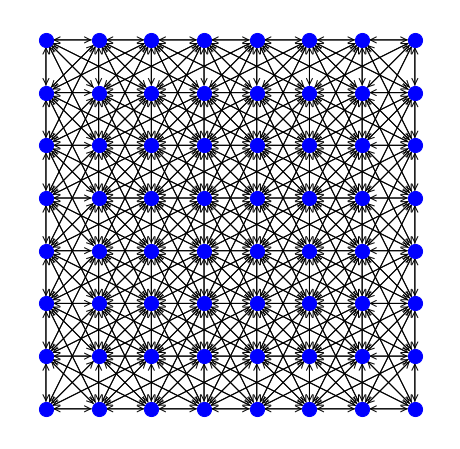

In [12]:
L = 2
Cs = CoprimesSet(L)
G1 = BuildGridNetwork(8, Cs)
PlotGridNetwork(G1)

Note that the degree of every node is limited, and much smaller than the case where every node (location) is connected with every other possible locations, as in the bipartite graphs. 

Let us try with a large value of $L$.

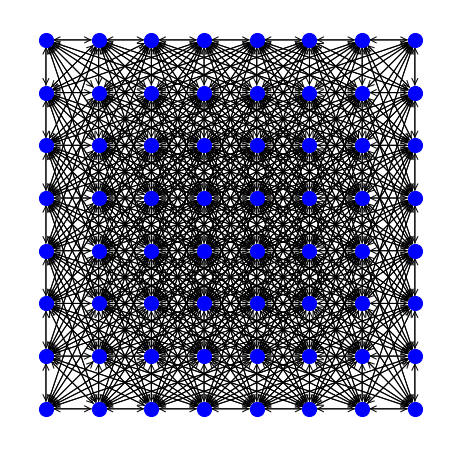

In [13]:
L = 3
Cs = CoprimesSet(L)
G1 = BuildGridNetwork(8, Cs)
PlotGridNetwork(G1)

## Solving the Flow Problem
Given a grid (flow) network $G$, and a pair of discrete measures defined over the grid, we can build the following LP model.

In [14]:
def ApproximateDistanceW1_L2(Mu, Nu, G):
    t0 = time()
    # Number of egdes
    m = len(G.edges())
    # Main Pyomo model
    model = ConcreteModel()
    # Parameters
    model.E = RangeSet(m)
    # Variables
    model.PI = Var(model.E, within=NonNegativeReals) 
    # Map edges to cost
    C = np.zeros(m)
    M = {}
    for e, (i, j) in enumerate(G.edges()):
        C[e] = G.edges[i,j]['weight']
        M[i,j] = e+1
        
    # Objective Function
    model.obj = Objective(expr=sum(model.PI[e] * C[e-1] for e in model.PI))
       
    # Flow balance constraints (using marginals balance at each location)
    model.Flow = ConstraintList()
    for v in G.nodes():
        Fs = [M[w] for w in G.out_edges(v)] 
        Bs = [M[w] for w in G.in_edges(v)] 

        # Compute flow balance value at given node position
        x = G.nodes[v]['pos']
        b = Mu.D.get(x, 0.0) - Nu.D.get(x, 0.0)
        
        # Flow balance constraint
        model.Flow.add(expr = sum(model.PI[e] for e in Fs) - sum(model.PI[e] for e in Bs) == b)
   
    # Solve the model
    sol = SolverFactory('glpk').solve(model)

    # Get a JSON representation of the solution
    sol_json = sol.json_repn()
    # Check solution status
    if sol_json['Solver'][0]['Status'] != 'ok':
        return None
    if sol_json['Solver'][0]['Termination condition'] != 'optimal':
        return None

    return model.obj(), (time()-t0)

At this point, we can compute the distance between the same pair of discrete measures $Mu$ and $Nu$ defined before, but using our new LP model.

In [15]:
# We build a flow network of size 32x32, using L=3
L = 3
Cs = CoprimesSet(L)
G = BuildGridNetwork(GridSize, Cs)

# Compute distance and runtime with the approximate model
distB, runtimeB = ApproximateDistanceW1_L2(Mu, Nu, G)

# ... and to compare with previous solution
print("LB   Full = {:.5}, LB   Apx = {:.5}".format(distA, distB))
print("Time Full = {:.5}, Time Apx = {:.5}".format(runtimeA, runtimeB))

LB   Full = 2.3511, LB   Apx = 2.3558
Time Full = 10.58, Time Apx = 6.1425


Note that in this case, the difference in running time is limited, and it is dominanted by the time for building the model (Pyomo is not very fast with this respect, despite its flexibility).

The approximate model is much more efficent for **dense** discrete measures, such as, for instance, images, where every point of a regular grid has a weight strictly positive.

Let us look at the following example.

In [16]:
# Create two random measures
GridSize = 32
N = 900
Mu = Measure2D(N, GridSize, seed=13)
Nu = Measure2D(N, GridSize, seed=14)

# Compute distance and runtime
distA, runtimeA = BipartiteDistanceW1_L2(Mu, Nu)

# We build a flow network of size 32x32, using L=3
L = 3
Cs = CoprimesSet(L)
G = BuildGridNetwork(GridSize, Cs)

# Compute distance and runtime with the approximate model
distB, runtimeB = ApproximateDistanceW1_L2(Mu, Nu, G)

# ... and to compare with the previous solution optimal valur and runtime
print("LB   Full = {:.5}, LB   Apx = {:.5}".format(distA, distB))
print("Time Full = {:.5}, Time Apx = {:.5}".format(runtimeA, runtimeB))

LB   Full = 0.63854, LB   Apx = 0.63878
Time Full = 199.16, Time Apx = 7.8611


For additional details and more extensive computational experiments, we refer to the following paper.

### References
1. Bassetti, F., Gualandi, S. and Veneroni, M., 2020. [*On the Computation of Kantorovich--Wasserstein Distances Between Two-Dimensional Histograms by Uncapacitated Minimum Cost Flows*](https://epubs.siam.org/doi/abs/10.1137/19M1261195). **SIAM Journal on Optimization**, 30(3), pp.2441-2469.